##### Copyright 2019 The TensorFlow Authors.

In [37]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [38]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [2]:
train_dir = '/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/train2'
validation_dir = '/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation2'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 17484 files belonging to 2 classes.


2021-09-14 16:29:06.621428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-14 16:29:06.622367: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
print(train_dir)

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/train2


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1942 files belonging to 2 classes.


Show the first nine images and labels from the training set:

2021-09-14 16:29:07.329907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-14 16:29:07.330925: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600060000 Hz


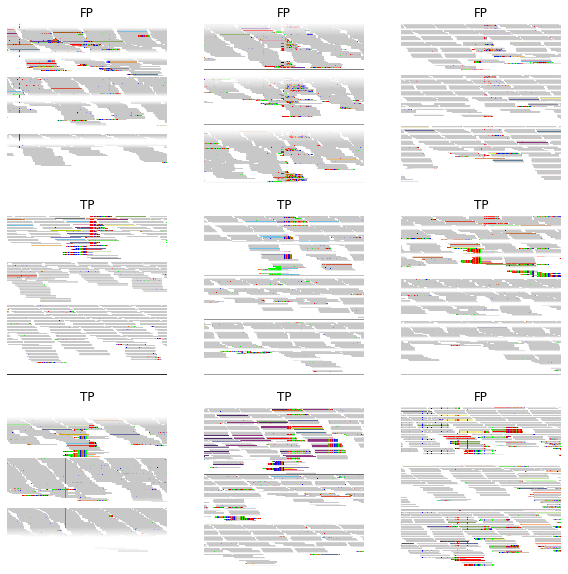

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 49
Number of test batches: 12


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [13]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/home/avt481/.conda/envs/tensor/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [20]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

49/49 [==============================] - 44s 655ms/step - loss: 0.8052 - accuracy: 0.5225


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.52


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
547/547 [==============================] - 423s 762ms/step - loss: 0.6276 - accuracy: 0.6306 - val_loss: 0.5047 - val_accuracy: 0.7311
Epoch 2/10
547/547 [==============================] - 428s 775ms/step - loss: 0.5273 - accuracy: 0.7239 - val_loss: 0.4740 - val_accuracy: 0.7542
Epoch 3/10
547/547 [==============================] - 412s 745ms/step - loss: 0.4929 - accuracy: 0.7478 - val_loss: 0.4487 - val_accuracy: 0.7754
Epoch 4/10
547/547 [==============================] - 411s 745ms/step - loss: 0.4762 - accuracy: 0.7641 - val_loss: 0.4300 - val_accuracy: 0.7927
Epoch 5/10
547/547 [==============================] - 411s 744ms/step - loss: 0.4612 - accuracy: 0.7755 - val_loss: 0.4220 - val_accuracy: 0.7908
Epoch 6/10
547/547 [==============================] - 413s 749ms/step - loss: 0.4481 - accuracy: 0.7856 - val_loss: 0.4169 - val_accuracy: 0.7997
Epoch 7/10
547/547 [==============================] - 411s 746ms/step - loss: 0.4427 - accuracy: 0.7885 - val_loss: 0.4099 -

In [ ]:
run1:
Epoch 1/10
503/503 [==============================] - 649s 1s/step - loss: 0.6812 - accuracy: 0.5922 - val_loss: 0.5888 - val_accuracy: 0.6500
Epoch 2/10
503/503 [==============================] - 580s 1s/step - loss: 0.5828 - accuracy: 0.6778 - val_loss: 0.5540 - val_accuracy: 0.6927
Epoch 3/10
503/503 [==============================] - 580s 1s/step - loss: 0.5410 - accuracy: 0.7137 - val_loss: 0.5342 - val_accuracy: 0.7186
Epoch 4/10
503/503 [==============================:] - 910s 2s/step - loss: 0.5225 - accuracy: 0.7279 - val_loss: 0.5083 - val_accuracy: 0.7330
Epoch 5/10
503/503 [==============================] - 581s 1s/step - loss: 0.5089 - accuracy: 0.7392 - val_loss: 0.5039 - val_accuracy: 0.7420
Epoch 6/10
503/503 [==============================] - 578s 1s/step - loss: 0.4940 - accuracy: 0.7479 - val_loss: 0.4931 - val_accuracy: 0.7583
Epoch 7/10
503/503 [==============================] - 578s 1s/step - loss: 0.4833 - accuracy: 0.7543 - val_loss: 0.4836 - val_accuracy: 0.7631
Epoch 8/10
503/503 [==============================] - 578s 1s/step - loss: 0.4766 - accuracy: 0.7635 - val_loss: 0.4806 - val_accuracy: 0.7661
Epoch 9/10
2021-08-09 13:30:48.743837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1 of 256
2021-08-09 13:30:49.605931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 42 of 256
2021-08-09 13:30:53.913476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
503/503 [==============================] - 601s 1s/step - loss: 0.4651 - accuracy: 0.7702 - val_loss: 0.4730 - val_accuracy: 0.7745
Epoch 10/10
503/503 [==============================] - 580s 1s/step - loss: 0.4600 - accuracy: 0.7740 - val_loss: 0.4604 - val_accuracy: 0.7841

In [ ]:
Run2:
    Epoch 1/10
503/503 [==============================] - 503s 986ms/step - loss: 0.6664 - accuracy: 0.5954 - val_loss: 0.6033 - val_accuracy: 0.6314
Epoch 2/10
503/503 [==============================] - 504s 992ms/step - loss: 0.5770 - accuracy: 0.6802 - val_loss: 0.5627 - val_accuracy: 0.6813
Epoch 3/10
503/503 [==============================] - 488s 961ms/step - loss: 0.5403 - accuracy: 0.7089 - val_loss: 0.5333 - val_accuracy: 0.7096
Epoch 4/10
503/503 [==============================] - 490s 964ms/step - loss: 0.5176 - accuracy: 0.7326 - val_loss: 0.5160 - val_accuracy: 0.7204
Epoch 5/10
503/503 [==============================] - 493s 970ms/step - loss: 0.5033 - accuracy: 0.7421 - val_loss: 0.5044 - val_accuracy: 0.7258
Epoch 6/10
503/503 [==============================] - 492s 968ms/step - loss: 0.4903 - accuracy: 0.7514 - val_loss: 0.4953 - val_accuracy: 0.7529
Epoch 7/10
503/503 [==============================] - 484s 953ms/step - loss: 0.4794 - accuracy: 0.7597 - val_loss: 0.4804 - val_accuracy: 0.7589
Epoch 8/10
503/503 [==============================] - 490s 964ms/step - loss: 0.4701 - accuracy: 0.7666 - val_loss: 0.4770 - val_accuracy: 0.7655
Epoch 9/10
503/503 [==============================] - 491s 967ms/step - loss: 0.4640 - accuracy: 0.7724 - val_loss: 0.4681 - val_accuracy: 0.7715
Epoch 10/10
503/503 [==============================] - 484s 952ms/step - loss: 0.4556 - accuracy: 0.7778 - val_loss: 0.4649 - val_accuracy: 0.7691

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [24]:
# save the model.
# !mkdir -p saved_model
model.save('saved_model/model2_step_01_transfer_learned_model_cleaned_input_10_epochs')
# later, to load the model
# model = tf.keras.models.load_model('saved_model/01_initial_transfer_learned_model')

2021-09-14 17:43:42.039719: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/avt481/.conda/envs/tensor/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_model/model2_step_01_transfer_learned_model_cleaned_input_10_epochs/assets


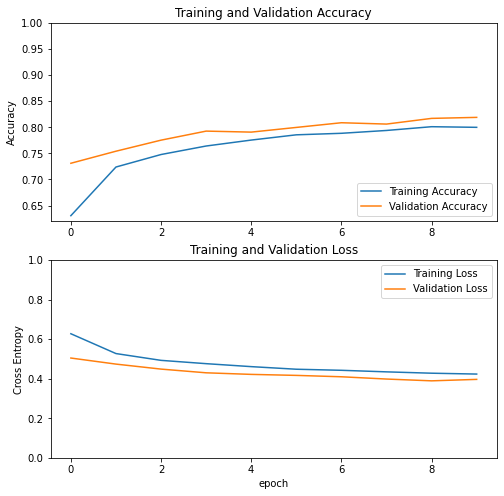

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/home/avt481/.conda/envs/tensor/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [30]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
547/547 [==============================] - 619s 1s/step - loss: 0.3730 - accuracy: 0.8419 - val_loss: 0.3575 - val_accuracy: 0.8761
Epoch 11/20
547/547 [==============================] - 613s 1s/step - loss: 0.3077 - accuracy: 0.8764 - val_loss: 0.2884 - val_accuracy: 0.8992
Epoch 12/20
547/547 [==============================] - 613s 1s/step - loss: 0.2768 - accuracy: 0.8900 - val_loss: 0.2681 - val_accuracy: 0.8877
Epoch 13/20
547/547 [==============================] - 611s 1s/step - loss: 0.2531 - accuracy: 0.9008 - val_loss: 0.2618 - val_accuracy: 0.8979
Epoch 14/20
547/547 [==============================] - 613s 1s/step - loss: 0.2373 - accuracy: 0.9091 - val_loss: 0.2642 - val_accuracy: 0.8954
Epoch 15/20
547/547 [==============================] - 611s 1s/step - loss: 0.2220 - accuracy: 0.9147 - val_loss: 0.2485 - val_accuracy: 0.8999
Epoch 16/20
547/547 [==============================] - 610s 1s/step - loss: 0.2074 - accuracy: 0.9207 - val_loss: 0.2687 - val_accuracy:

In [ ]:
run2:
Epoch 10/20
503/503 [==============================] - 683s 1s/step - loss: 0.3612 - accuracy: 0.8417 - val_loss: 0.2765 - val_accuracy: 0.8882
Epoch 11/20
503/503 [==============================] - 681s 1s/step - loss: 0.2580 - accuracy: 0.9008 - val_loss: 0.2538 - val_accuracy: 0.9158
Epoch 12/20
503/503 [==============================] - 689s 1s/step - loss: 0.2241 - accuracy: 0.9170 - val_loss: 0.2401 - val_accuracy: 0.9050
Epoch 13/20
503/503 [==============================] - 699s 1s/step - loss: 0.1996 - accuracy: 0.9258 - val_loss: 0.2034 - val_accuracy: 0.9194
Epoch 14/20
503/503 [==============================] - 680s 1s/step - loss: 0.1827 - accuracy: 0.9357 - val_loss: 0.2050 - val_accuracy: 0.9272
Epoch 15/20
503/503 [==============================] - 681s 1s/step - loss: 0.1682 - accuracy: 0.9390 - val_loss: 0.1930 - val_accuracy: 0.9296
Epoch 16/20
503/503 [==============================] - 687s 1s/step - loss: 0.1570 - accuracy: 0.9436 - val_loss: 0.1856 - val_accuracy: 0.9302
Epoch 17/20
503/503 [==============================] - 680s 1s/step - loss: 0.1462 - accuracy: 0.9477 - val_loss: 0.1971 - val_accuracy: 0.9248
Epoch 18/20
503/503 [==============================] - 693s 1s/step - loss: 0.1340 - accuracy: 0.9520 - val_loss: 0.2233 - val_accuracy: 0.9164
Epoch 19/20
503/503 [==============================] - 678s 1s/step - loss: 0.1255 - accuracy: 0.9559 - val_loss: 0.2047 - val_accuracy: 0.9254
Epoch 20/20
503/503 [==============================] - 687s 1s/step - loss: 0.1157 - accuracy: 0.9582 - val_loss: 0.2064 - val_accuracy: 0.9284

In [32]:
model.save('saved_model/model2_step_02_transfer_learned_model_cleaned_input_20_epochs_fine_tuned')

/home/avt481/.conda/envs/tensor/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_model/model2_step_02_transfer_learned_model_cleaned_input_20_epochs_fine_tuned/assets


In [72]:
# check on FP's
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
img_path = "/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/*"
imgs = glob.glob(img_path)
count = 0
for i in imgs:
    img = image.load_img(i, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    predictions = tf.nn.sigmoid([prediction])
    predictions = tf.where(predictions < 0.5, 0, 1)
    if predictions.numpy()[0][0][0] == 1: # 1 == TP prediction
        print(i)
        count += 1
print(count)
        

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_VQ4QEK0X_chr6_8369218_8369219.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_J12ERCJX_chr8_68674895_68674896.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_N9MPHKFK_chr12_121784274_121784275.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_GV6ENB1E_chr6_32612451_32612452.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_QFYKJW7Z_chr13_49599222_49599223.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_MD68DFCH_chr3_141112644_141112645.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/ma

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_N9MPHKFK_chr5_29922671_29922672.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_MBHQ0GD3_chr15_69373916_69373917.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_V5CCAJB5_chr3_109322777_109322778.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_YF2SSTEX_chr18_27864910_27864911.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_THSHJX5T_chr1_224259839_224259840.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_SPF8K560_chr20_50445165_50445166.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_T1MR2K5C_chr8_18408232_18408233.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_RN931X19_chr12_4377448_4377449.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_GV6ENB1E_chr12_10048095_10048096.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_T1MR2K5C_chr11_63832039_63832040.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_T1MR2K5C_chr5_157864024_157864025.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_GV6ENB1E_chr6_135916410_135916411.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/m

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_K4V4QQVR_chr19_41875211_41875212.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_XW92SJ5F_chr5_137434510_137434511.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_T1RBN0PE_chr18_38537997_38537998.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_T1MR2K5C_chr4_24903912_24903913.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_QQRY6KJ0_chr22_36086537_36086538.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_PMB7A8JM_chr6_71710582_71710583.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/m

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_WNF4XZRW_chr14_73821518_73821519.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_XW92SJ5F_chr2_215682957_215682958.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_QFYKJW7Z_chr3_186751316_186751317.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_RG7KMJ46_chr10_103684791_103684792.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_GN4PWZY4_chr10_67302071_67302072.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_Y4N89SXG_chr8_20122785_20122786.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntu

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_VQ4QEK0X_chr17_44513444_44513445.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_XW92SJ5F_chr14_70223501_70223502.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_V1WZZGBN_chr6_29795780_29795781.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/FP/ewing_sarcoma_FP/Alu/Alu_FM_THSHJX5T_chr17_46105634_46105635.png
270


In [ ]:
Epoch 10/20
503/503 [==============================] - 831s 2s/step - loss: 0.3686 - accuracy: 0.8376 - val_loss: 0.3967 - val_accuracy: 0.7968
Epoch 11/20
503/503 [==============================] - 838s 2s/step - loss: 0.2633 - accuracy: 0.8967 - val_loss: 0.2329 - val_accuracy: 0.9062
Epoch 12/20
503/503 [==============================] - 804s 2s/step - loss: 0.2244 - accuracy: 0.9154 - val_loss: 0.2221 - val_accuracy: 0.9200
Epoch 13/20
503/503 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9262
2021-08-09 14:55:53.518615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 248 of 256
2021-08-09 14:55:53.831154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
503/503 [==============================] - 905s 2s/step - loss: 0.2002 - accuracy: 0.9262 - val_loss: 0.2203 - val_accuracy: 0.9296
Epoch 14/20
503/503 [==============================] - 822s 2s/step - loss: 0.1836 - accuracy: 0.9340 - val_loss: 0.2807 - val_accuracy: 0.8870
Epoch 15/20
503/503 [==============================] - 819s 2s/step - loss: 0.1718 - accuracy: 0.9390 - val_loss: 0.2061 - val_accuracy: 0.9321
Epoch 16/20
478/503 [===========================>..] - ETA: 45s - loss: 0.1586 - accuracy: 0.9450

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

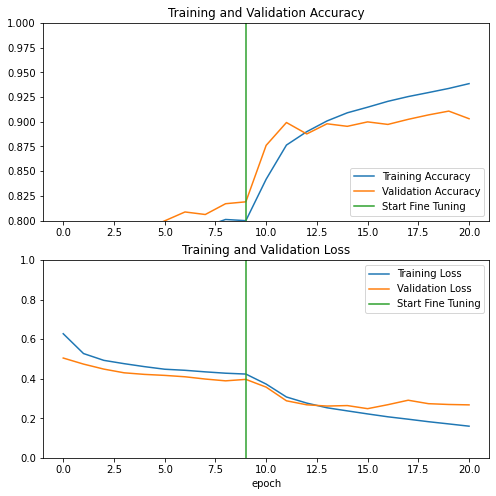

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 12s 657ms/step - loss: 0.2905 - accuracy: 0.9062
Test accuracy : 0.90625


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0]
Labels:
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0]


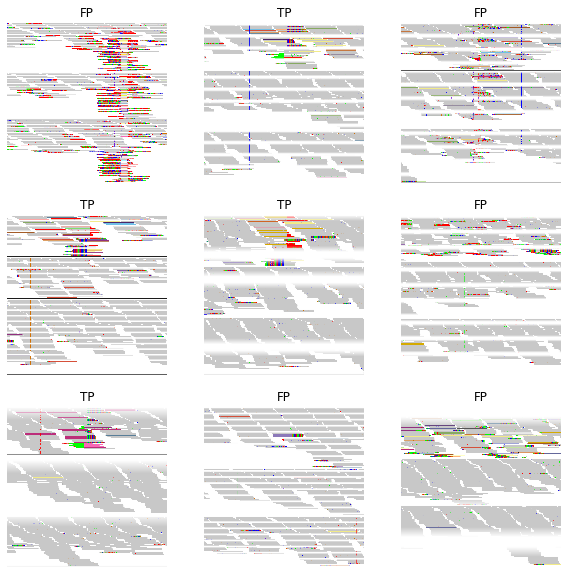

In [36]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [37]:
# test with real TPs
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
img_path = "/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/*"

imgs = glob.glob(img_path)
tps=0
fps=0
for i in imgs:
    img = image.load_img(i, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    predictions = tf.nn.sigmoid([prediction])
    predictions = tf.where(predictions < 0.5, 0, 1)
#     print(predictions.numpy()[0][0][0])
    if predictions.numpy()[0][0][0] == 1: # 1 == TP prediction
        tps += 1
    else:
        fps += 1
        print(i)
print("TPs " + str(tps))
print("FPs " + str(fps))

/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/FM_3K5A00G1_chr20_52280737_52280738_for_transfer_learning.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/FM_YVS68TM9_chr22_28304307_28304308_for_transfer_learning.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/FM_5PKA7B0T_chr6_7250370_7250371_for_transfer_learning.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/FM_B50FJX4T_chr1_78643160_78643161_for_transfer_learning.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/FM_D6Q58PRT_chr9_81870259_81870260_for_transfer_learning.png
/n/data1/hms/dbmi/park/simon_chu/projects/shared/toAntuan/machine_learning_training_data/validation/TP2_kids_first/FM_17